In [1]:
import sys
from pathlib import Path

repo_root = Path.cwd().resolve().parents[1]  # …/collision_of_two_bodies
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np


In [7]:
def build_config(overrides=None):
    base = Config()
    if overrides:
        base = Config(**overrides)
    set_global_seeds(base.seed)
    return base

import logging

def run_case(case_name, overrides=None, verbose=True):
    cfg = build_config(overrides)
    base_logger = setup_logger()
    logger = logging.getLogger(f"case_{case_name.lower().replace(' ', '_')}")
    logger.setLevel(base_logger.level)
    if not logger.handlers:
        for h in base_logger.handlers:
            logger.addHandler(h)

    controller = ContinuousOptimizationController(cfg, logger=logger if verbose else None)
    result = controller.run()
    if verbose:
        logger.info("→ %s | mejor λ ≈ %.4f", case_name, -(result["best"]["lambda"] or float("nan")))
        print(result)
    return cfg, result


def visualize_best(cfg, result, horizon="short", show=False):
    best = result.get("best") or {}
    m1, m2 = best.get("m1"), best.get("m2")
    if m1 is None or m2 is None:
        print("Sin candidato válido para visualizar.")
        return

    masses = (m1, m2)
    r0 = tuple(cfg.r0[i] for i in range(len(masses)))
    v0 = tuple(cfg.v0[i] for i in range(len(masses)))

    sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
    sim = sim_builder.setup_simulation(masses=masses, r0=r0, v0=v0)
    t_end = cfg.t_end_short if horizon == "short" else cfg.t_end_long
    traj = sim_builder.integrate(sim, t_end=t_end, dt=cfg.dt)

    xy_tracks = [traj[:, idx, :2] for idx in range(traj.shape[1])]
    viz = Visualizer(headless=not show)
    viz.quick_view(xy_tracks, title=f"Trayectorias {best['m1']:.3f}, {best['m2']:.3f}")
    return xy_tracks


In [4]:
cases = {
    "Caso A (baseline)": {},
    "Caso B (semilla distinta)": {"seed": 123},
    "Caso C (búsqueda acotada)": {
        "m1_bounds": (0.8, 1.2),
        "m2_bounds": (0.8, 1.2),
        "local_radius": 0.05,
    },
}


In [8]:
results = {}
for name, overrides in cases.items():
    cfg, result = run_case(name, overrides=overrides)
    results[name] = (cfg, result)


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-10-19 17:18:21,634] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:23,797] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:24,274] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:24,757] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:25,039] INFO - → Caso A (baseline) | mejor λ ≈ 5.0063


{'status': 'completed', 'best': {'m1': 5.542514883359378, 'm2': 7.104769895312113, 'lambda': -5.006276343682708, 'fitness': 5.006276343682708}, 'evals': 3600, 'epochs': 50}


[2025-10-19 17:18:25,692] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:26,162] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:26,627] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:27,112] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:27,965] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:28,442] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:28,913] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:29,376] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:29,753] INFO - → Caso B (semilla distinta) | mejor λ ≈ 5.0235


{'status': 'completed', 'best': {'m1': 6.764156391327209, 'm2': 5.883385117379064, 'lambda': -5.0234596002926795, 'fitness': 5.0234596002926795}, 'evals': 3600, 'epochs': 50}


[2025-10-19 17:18:30,268] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:30,724] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:31,160] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:31,598] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:32,029] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:32,470] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:32,906] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:33,342] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:33,779] INFO - Stagnation detected; reseeding around best candidate.
[2025-10-19 17:18:34,130] INFO - → Caso C (búsqueda acotada) | mejor λ ≈ 0.0002


{'status': 'completed', 'best': {'m1': 0.8441694247541521, 'm2': 0.9715852245536836, 'lambda': -0.00022600595547919876, 'fitness': 0.00022600595547919876}, 'evals': 3600, 'epochs': 50}


Visualizando Caso A (baseline)


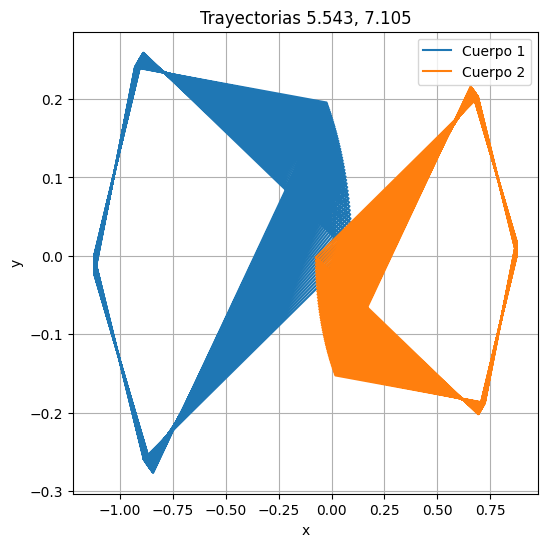

Visualizando Caso B (semilla distinta)


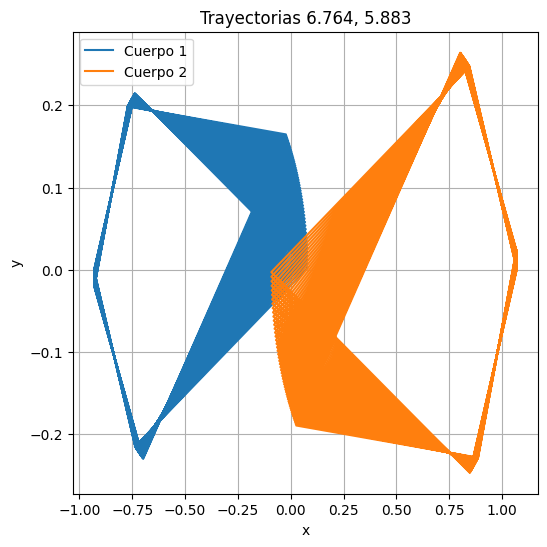

Visualizando Caso C (búsqueda acotada)


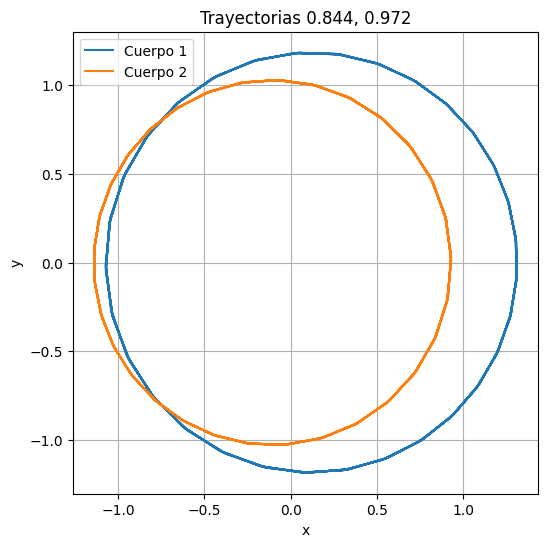

In [10]:
for name, (cfg, result) in results.items():
    print(f"Visualizando {name}")
    visualize_best(cfg, result, horizon="short", show=True)
